In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import f_regression

plt.rcParams.update({'font.size': 20})
sns.set_style("darkgrid")

In [8]:
df_x = pd.read_csv('../dataset/1-preprocessed/X.csv')
df_y = pd.read_csv('../dataset/1-preprocessed/y.csv')
df = df_x.merge(df_y).drop(['id','faulty'], axis=1)

## Correlation pruning
Prior to feature selection, we're going to prune highly correlated (thus most probably redundant) features.

In [9]:
correlation_matrix = df.corr()

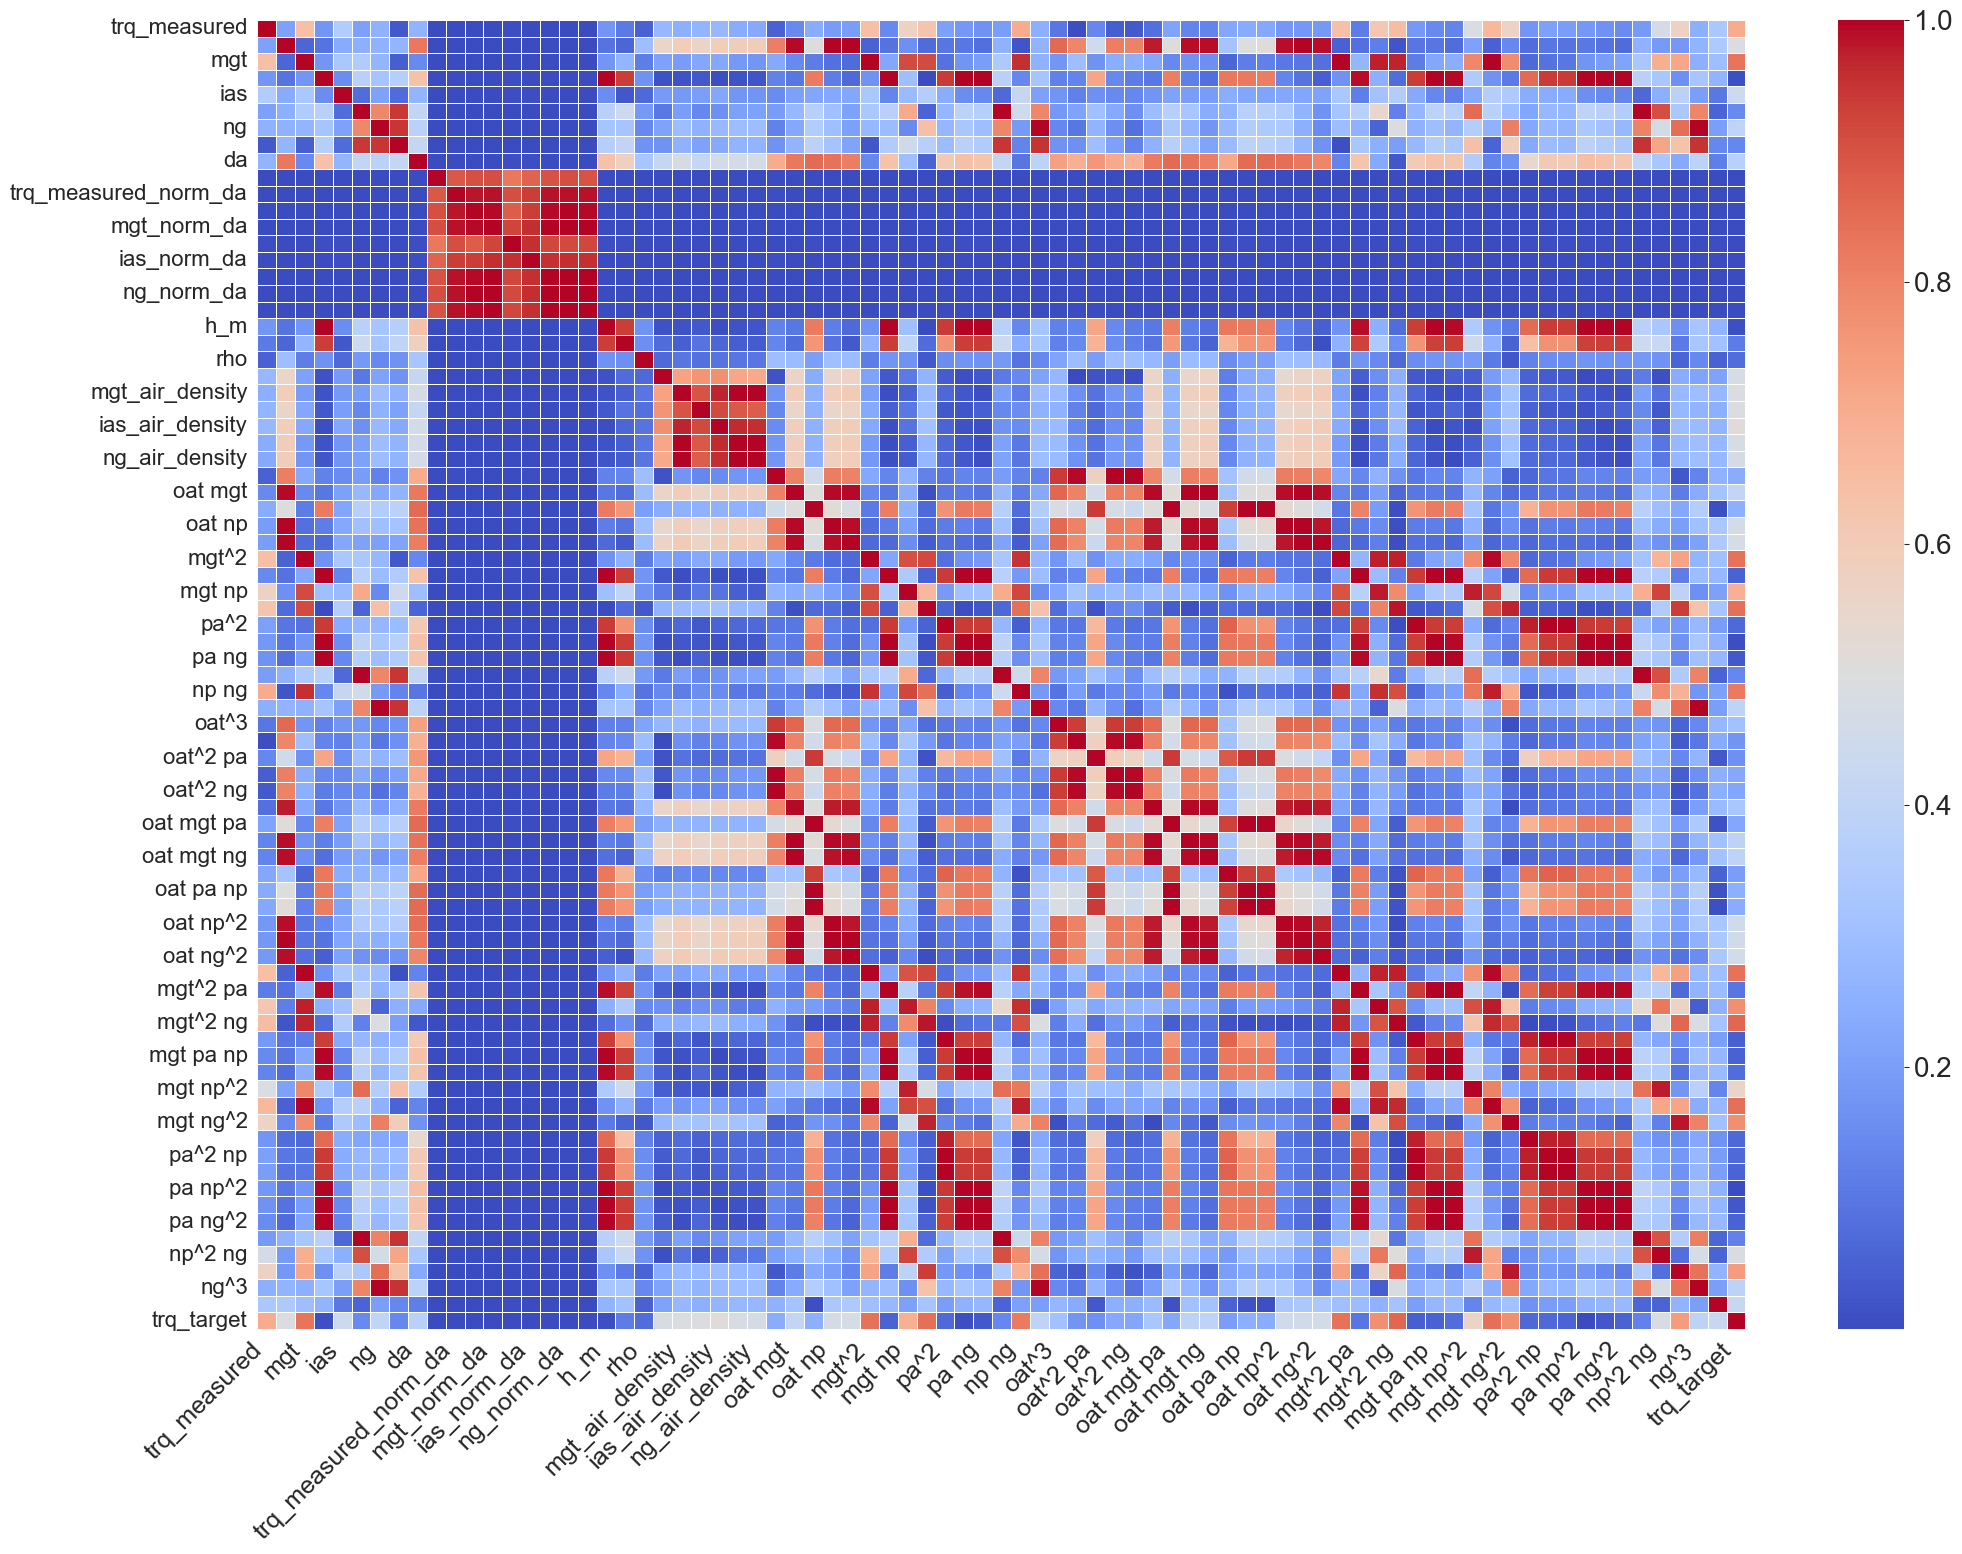

In [10]:
plt.figure(figsize=(24, 17))
sns.heatmap(correlation_matrix.abs(), annot=False, fmt=".2f", linewidths=0.4, cbar=True, cmap='coolwarm')
plt.xticks(rotation=45, ha="right", fontsize=18)
plt.yticks(fontsize=16)
plt.show()

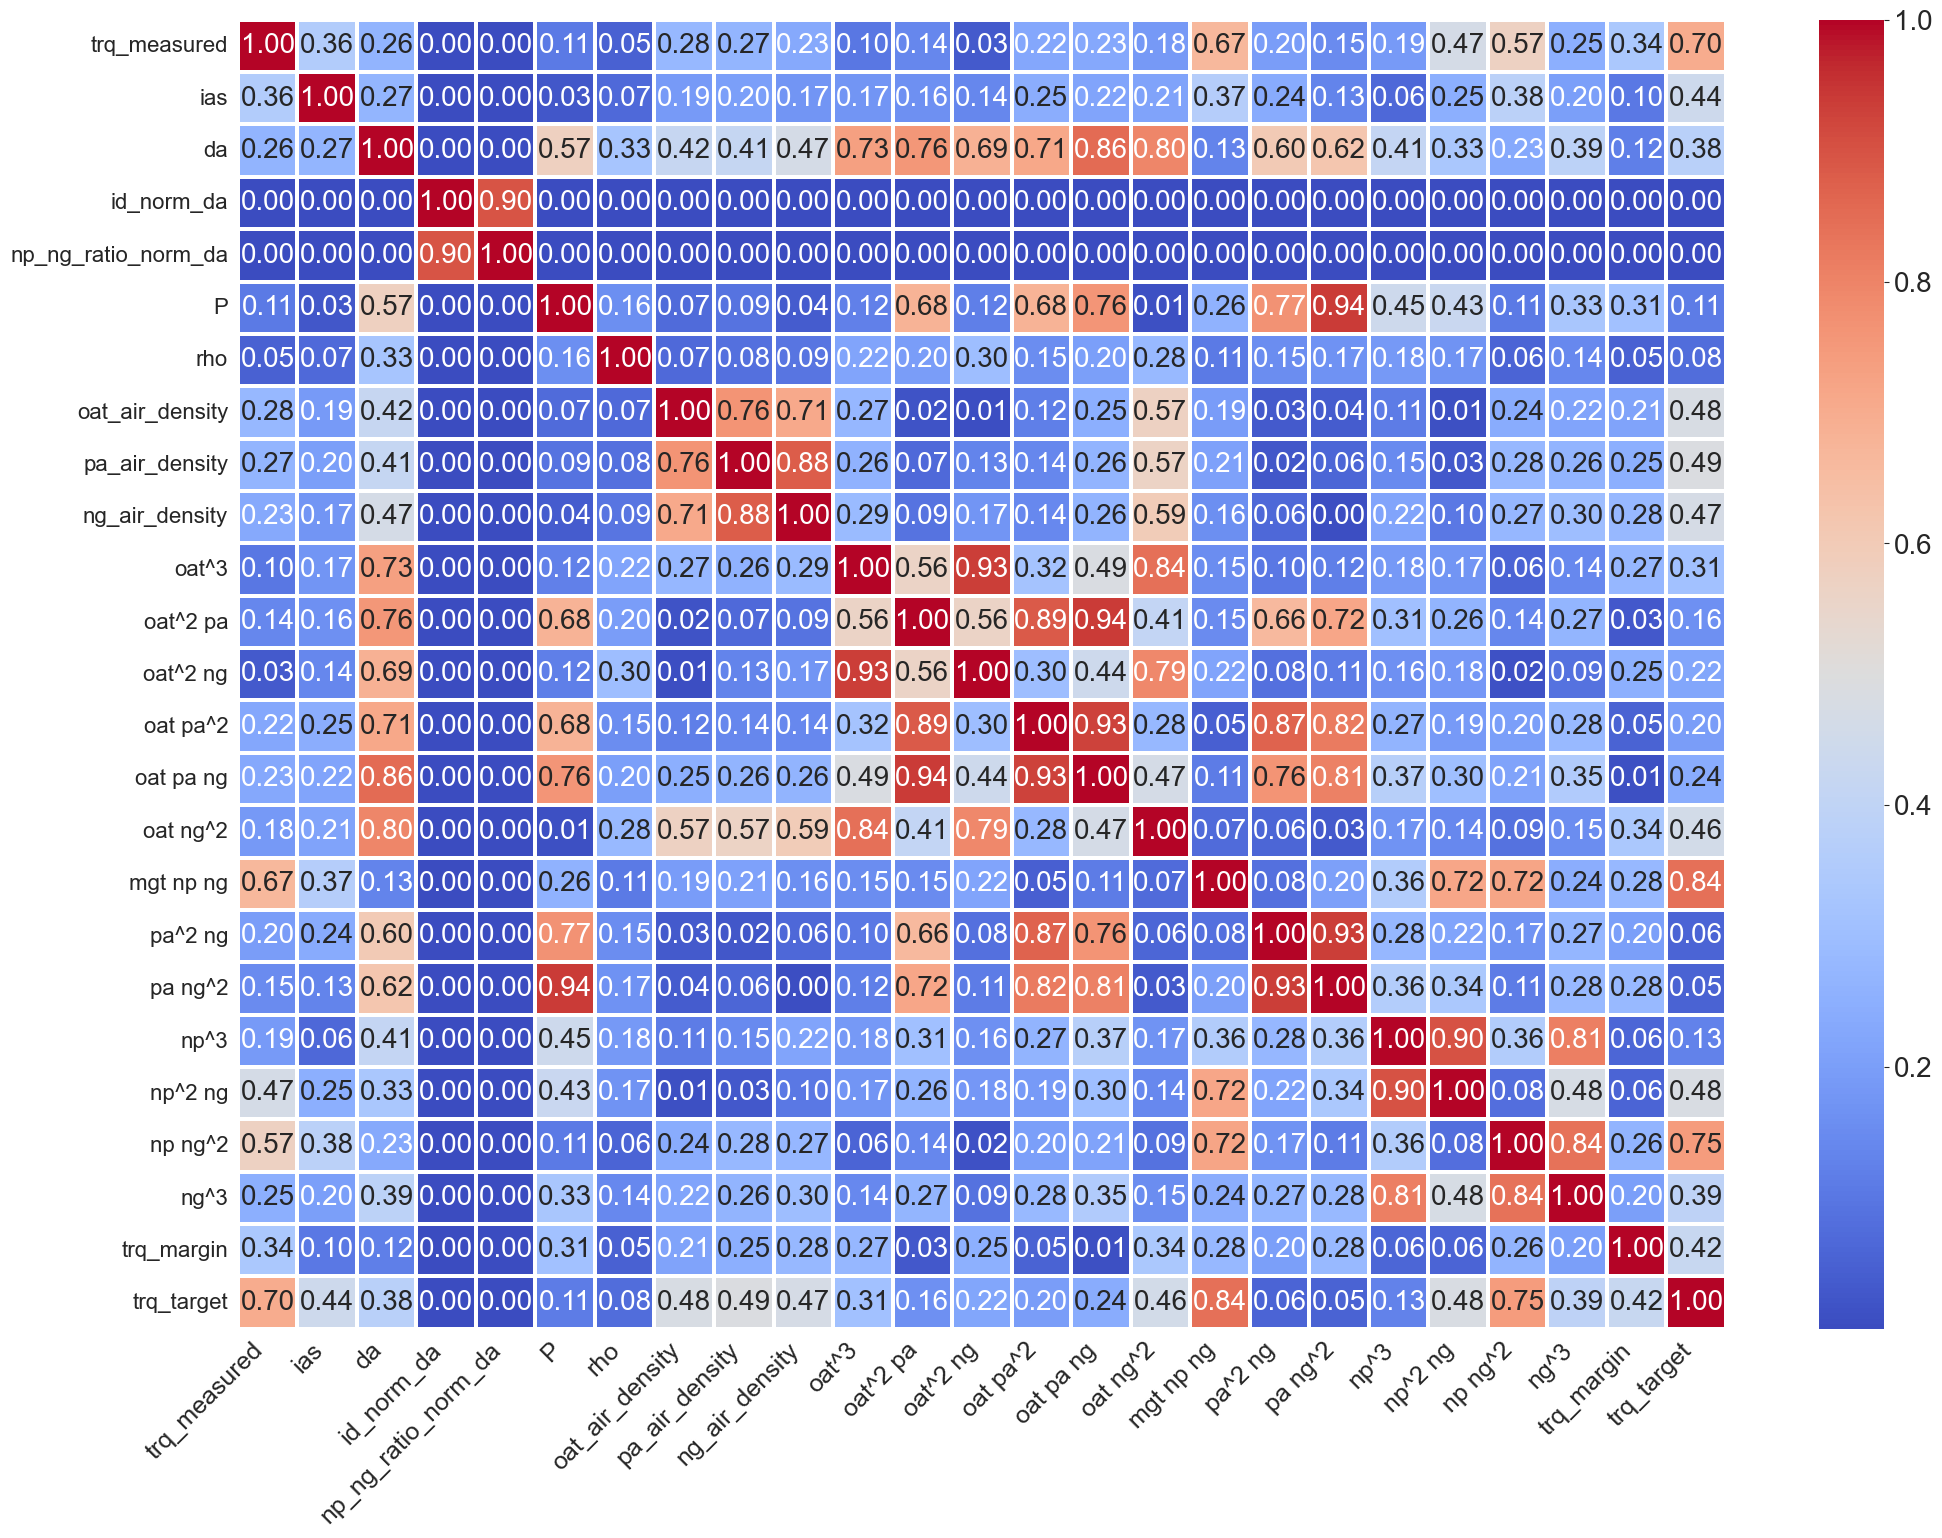

In [11]:
threshold = 0.95

# Find pairs of highly correlated features
high_corr_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.add((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Determine which features to drop (just pick one from each pair)
features_to_drop = set([pair[1] for pair in high_corr_pairs])

plt.figure(figsize=(24, 17))
pruned_correlation_matrix = correlation_matrix.drop(features_to_drop, axis=0).drop(features_to_drop, axis=1).abs()
sns.heatmap(pruned_correlation_matrix, annot=True, fmt=".2f", linewidths=1.5, cbar=True, cmap='coolwarm')
plt.xticks(rotation=45, ha="right", fontsize=18)
plt.yticks(fontsize=16)
plt.show()

## Correlation with target
Dropping features that are less correlated with the target is based on the idea that features with little or no relationship to the outcome are unlikely to improve—and might even harm—the predictive performance of the model.

Features with low correlation might be dropped, but we must remember to check for multicollinearity among features as well.

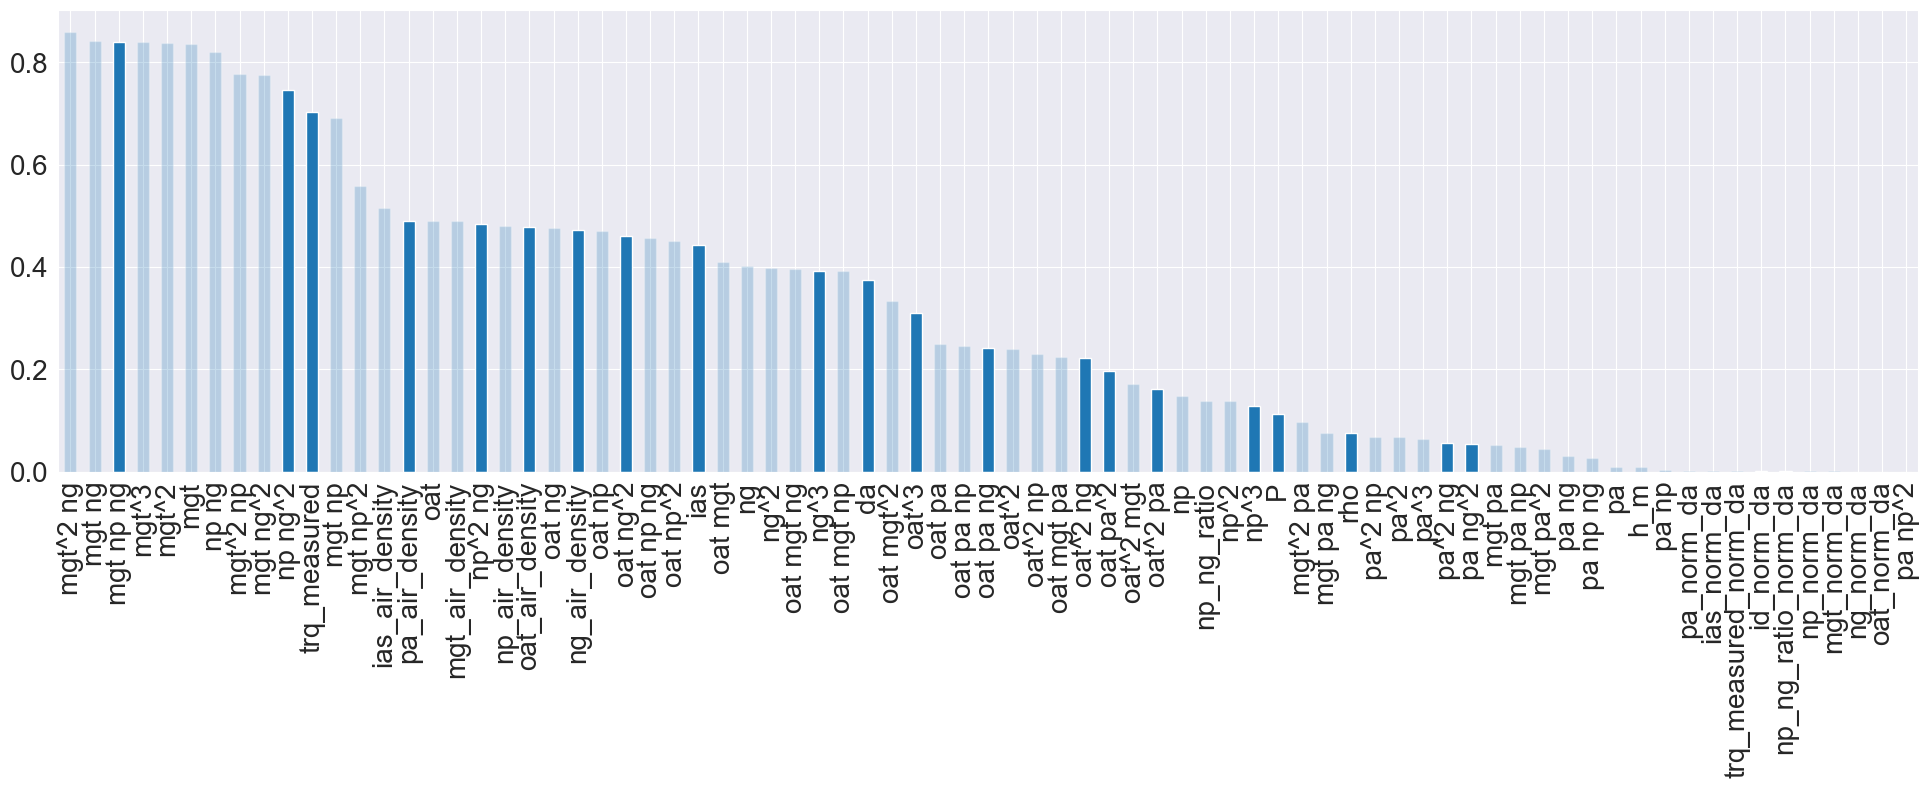

In [12]:
target_correlations = (correlation_matrix['trq_target'].drop(['trq_margin', 'trq_target']).abs()
                       .sort_values(ascending=False))
plt.figure(figsize=(24, 6))
ax = target_correlations.plot(kind='bar')
alphas = [0.25 if x in features_to_drop else 1.0 for x in target_correlations.index]
for bar, alpha in zip(ax.patches, alphas):
    bar.set_alpha(alpha)


## ANOVA F-test ranking
Evaluates whether each feature has a significant linear relationship with the target. **In a nutshell it computes the cross-correlation between each feature and the target and finds the probability of the null-Hp using the Fisher distribution**. A high F-score (with a corresponding low p-value) indicates that the feature is more likely to be significantly associated with the target variable

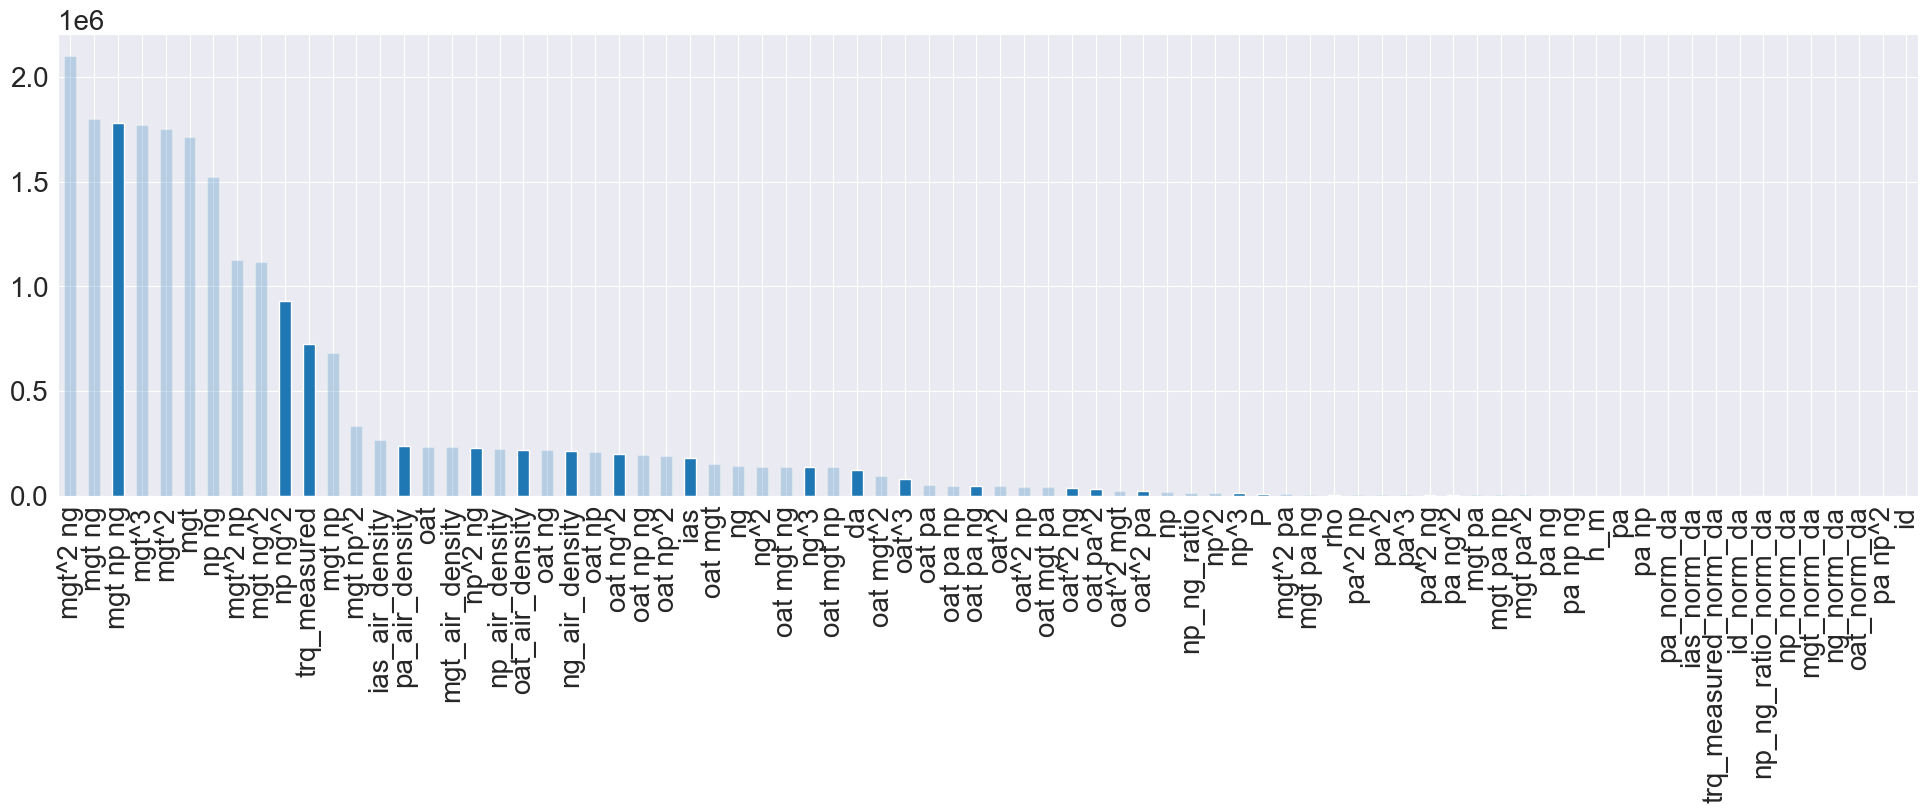

In [13]:
F, p_values = f_regression(df_x, df['trq_target'])
f_scores = pd.Series(F, index=df_x.columns).sort_values(ascending=False)
ax = f_scores.plot(kind='bar', figsize=(24, 6))
for bar, alpha in zip(ax.patches, alphas):
    bar.set_alpha(alpha)

## Comparing the results of the two indicators and selecting the features

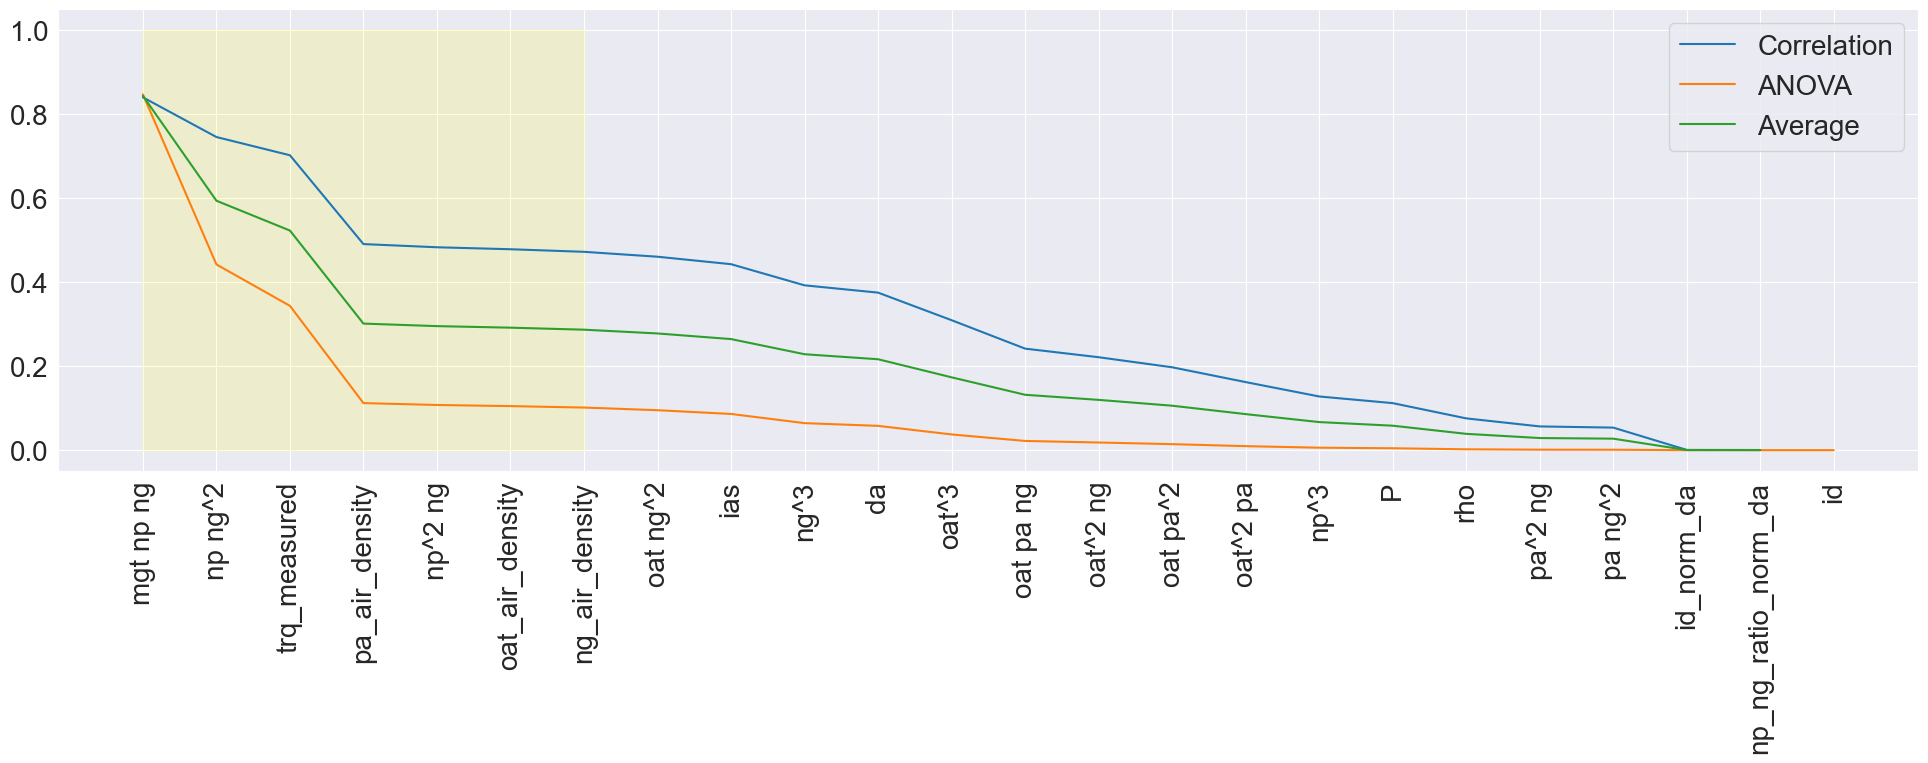

In [14]:
features_to_keep = 7
result1 = np.abs(target_correlations)
result2 = f_scores / f_scores.max()
mean_result = (result1 + result2) / 2
result = (pd.DataFrame({'Correlation': result1, 'ANOVA': result2, 'Average': mean_result})
          .sort_values(by='Average', ascending=False).drop(features_to_drop))
ax = result.plot(kind='line', figsize=(24, 6))
ax.set_xticks(range(len(result.index)))
ax.set_xticklabels(result.index, rotation=90)
ax.fill_between(range(features_to_keep), 1, alpha=0.15, color='yellow')
plt.show()

In [15]:
selected_features = df_x[result.index.values[:features_to_keep]]
selected_features.to_csv('../dataset/2-regression/X.csv', index=False)
df_y[['trq_target']].to_csv('../dataset/2-regression/y.csv', index=False)